## **Analysis of the elevation change rate drived by dems.**
#### 1) Elevation change rate correction with the linear fitting of elevation changes on the stable region. 
#### $(\frac{dh}{dt})_{glacier-cor} = (\frac{dh}{dt})_{glacier} - (\frac{dh}{dt})_{stable}$
#### 2) Uncertainty estimation of elevation change rate. 
#### $\epsilon_{ransac} = y_i - y_{fitting}$
#### $\sigma_{dh} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(\epsilon_{i} - \overline{\epsilon})^2} $
#### $\sigma_\frac{dh}{dt} = \frac{\sigma_{dh}}{dt}$
The n refer to the number of the years, and the i is the i-th year.

### comtent
1. Elevation change on the stable region (For elevation change correction and uncertainty estimation).
- 1.1 Elevation change on the overall setp stable region.
- 1.2 Elevation change on one tile.
2. Elevation change on the glacier region.
- 2.1. Elevation change on the overall setp region.
- 2.2 Elevation change of tiles.
- 2.3 Elevation changes of elevation bins.
3. Write out the result.


In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from utils.ransac_fitting import ransac_fitting
import pandas as pd
import xarray as xr
from utils.tiles_bins_weighting import stat_tiles_weighting, stat_bins_tiles_weighting, stat_tiles_bins_weighting


In [3]:
paths_stat_dems = 'data/aster-stereo/stat_dif_tiles_bins.nc'   ## path of statistics 
path_result_dems = 'data/aster-stereo/result_dems.nc'


In [4]:
stat_dif_dems_xr = xr.open_dataset(paths_stat_dems)
stat_dif_dems_xr
tiles_id = stat_dif_dems_xr.tiles_id.values
bins_id = stat_dif_dems_xr.bins_id.values
years = stat_dif_dems_xr.years.values
x_years = np.array([i for i in range(len(years))])
len(years)


23

### 1. Elevation change on the stable region.

#### 1.1 Elevation change on the overall setp stable region.

Ransac coefficient for stable setp region: 0.010990542988923852


(-15.0, 10.0)

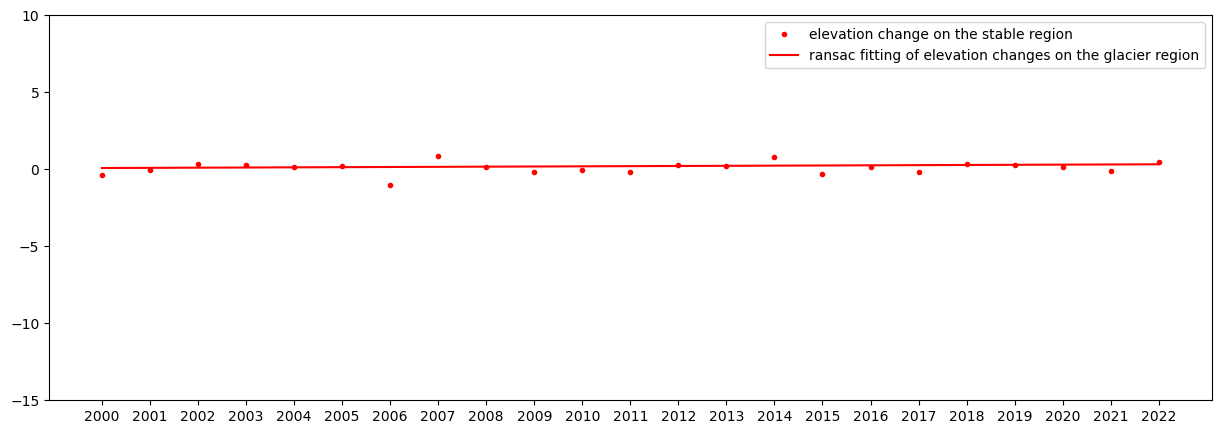

In [5]:
mean_setp_stable_tilesWeighted, std_setp_stable_tilesWeighted = stat_tiles_weighting(mean_tiles = stat_dif_dems_xr['mean_stable_tiles'], \
                                                                    std_tiles = stat_dif_dems_xr['std_stable_tiles'], 
                                                                    glacier_area_tiles = stat_dif_dems_xr['area_glacier_tiles'])
mean_setp_stable_filtered, mean_setp_stable_fitting, rate_setp_stable = ransac_fitting(x=x_years, y=mean_setp_stable_tilesWeighted.values, thre_mask=50)
print('Ransac coefficient for stable setp region:', rate_setp_stable[0])
plt.figure(figsize=(15, 5))
plt.plot(years, mean_setp_stable_tilesWeighted, '.r', label='elevation change on the stable region')
plt.plot(years, mean_setp_stable_fitting, '-r', label='ransac fitting of elevation changes on the glacier region')   ### bin-based area weighting -> tile-based area weighting
plt.legend()
plt.ylim(bottom=-15, top=10)



#### 1.2 Check the elevation change on one tile.

Ransac coefficient for stable tile: 0.02200577948947046


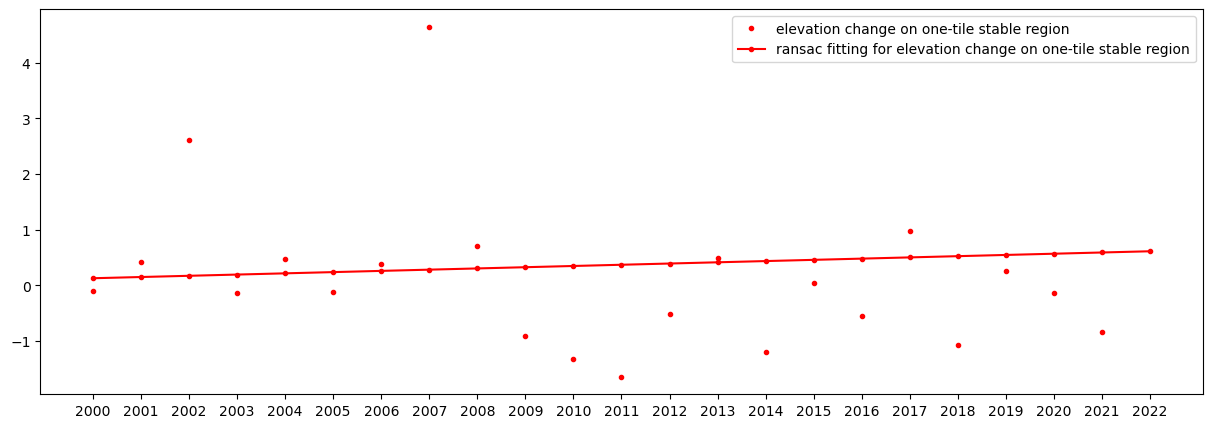

In [6]:
tile_sel = 'tile_29_97'
mean_stable_tile_filtered, mean_stable_tile_fitting, rate_stable_tile = ransac_fitting(x=x_years, \
                                        y=stat_dif_dems_xr['mean_stable_tiles'].sel(tiles_id=tile_sel).values, thre_mask=50)
# mean_glacier_tile_filtered, mean_glacier_tile_fitting, rate_glacier_tile = ransac_fitting(x=x_years, \
#                                         y=mean_tiles_glacier_binsWeighted.sel(tiles_id=tile_sel).values, thre_mask=50)
print('Ransac coefficient for stable tile:', rate_stable_tile[0])
# print('Ransac coefficient for glacier tile:', rate_glacier_tile[0])

plt.figure(figsize=(15, 5))
plt.plot(years, stat_dif_dems_xr['mean_stable_tiles'].sel(tiles_id=tile_sel), '.r', label='elevation change on one-tile stable region')
plt.plot(years, mean_stable_tile_fitting, '.-r', label='ransac fitting for elevation change on one-tile stable region')
# plt.plot(years, mean_tiles_glacier_binsWeighted.sel(tiles_id='tile_29_97'), '.g', label='elevation change on one-tile glacier region')
# plt.plot(years, mean_glacier_tile_fitting, '.-g', label='ransac fitting for elevation change on one-tile')
plt.legend()




### 2. Elevation change on the glacier region.


#### 2.1 Elevation change on the overall setp region.

##### 2.1.1 Glacier area weighted elevation change on the glacier region.

In [7]:
### From bins weighting to tiles weighting.
mean_tiles_glacier_binsWeighted, std_tiles_glacier_binsWeighted, mean_setp_glacier_tilesWeighted, std_setp_glacier_tilesWeighted = \
                                stat_bins_tiles_weighting(mean_tiles_bins=stat_dif_dems_xr['mean_glacier_tiles_bins'], \
                                                    std_tiles_bins=stat_dif_dems_xr['std_glacier_tiles_bins'], 
                                                    glacier_area_tiles_bins=stat_dif_dems_xr['area_glacier_tiles_bins'])

### From tiles weighting to bins weighting.
mean_bins_glacier_tilesWeighted, std_bins_glacier_tilesWeighted, mean_setp_glacier_binsWeighted, std_setp_glacier_binsWeighted = \
                                            stat_tiles_bins_weighting(mean_tiles_bins=stat_dif_dems_xr['mean_glacier_tiles_bins'], \
                                                            std_tiles_bins=stat_dif_dems_xr['std_glacier_tiles_bins'], 
                                                            glacier_area_tiles_bins=stat_dif_dems_xr['area_glacier_tiles_bins'])



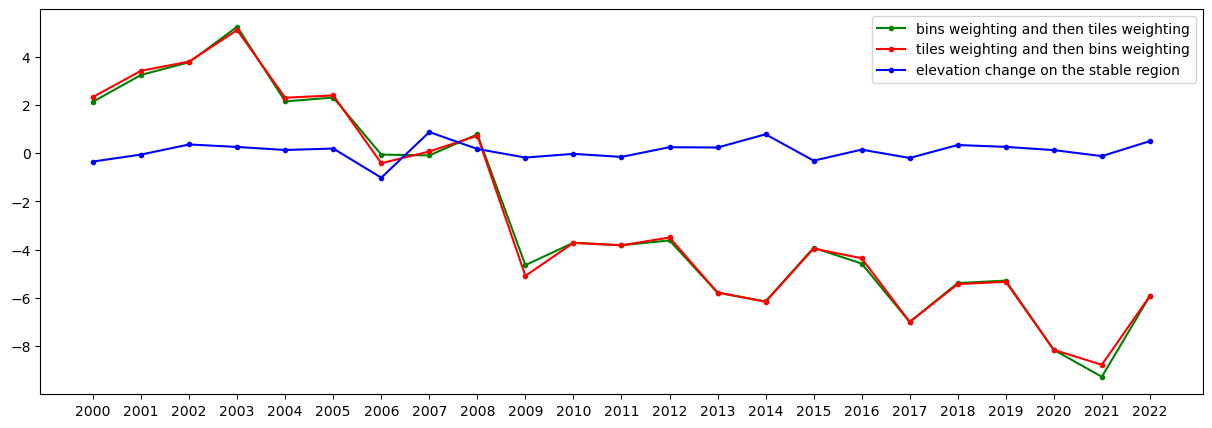

In [8]:
plt.figure(figsize=(15,5))
plt.plot(years, mean_setp_glacier_tilesWeighted, '.-g', label='bins weighting and then tiles weighting')   ### bin-based area weighting -> tile-based area weighting
plt.plot(years, mean_setp_glacier_binsWeighted, '.-r', label='tiles weighting and then bins weighting')   ### tile-based area weighting -> bin-based area weighting
plt.plot(years, mean_setp_stable_tilesWeighted, '.-b', label='elevation change on the stable region')
plt.legend()



##### 2.1.2 Elevation change correction with elevation chang on the stable region
##### **!!!! Note: the elevation changes much from 2008 to 2009.** 

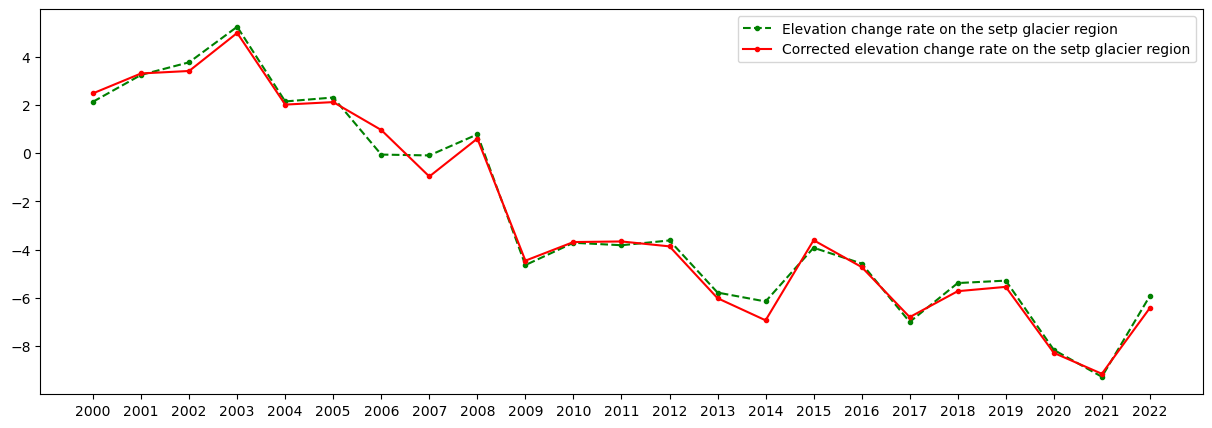

In [9]:
## New method.
### elevation change
mean_setp_glacier_cor = mean_setp_glacier_tilesWeighted.values - mean_setp_stable_tilesWeighted.values
# mean_setp_glacier_cor_filtered, mean_setp_glacier_cor_fitting, rate_setp_glacier_cor = ransac_fitting(x=x_years, \
#                                         y=mean_setp_glacier_cor, thre_mask=50)
### standard deviation of elevation change.
std_setp_glacier_cor = np.sqrt(np.square(std_setp_stable_tilesWeighted.values) + np.square(std_setp_glacier_tilesWeighted.values)) 

# print('Corrected elevation change rate for the overall setp glacier region:', ransac_coef_setp_glacier_cor[0])
plt.figure(figsize=(15, 5))
plt.plot(years, mean_setp_glacier_tilesWeighted.values, '.--g', label='Elevation change rate on the setp glacier region')
plt.plot(years, mean_setp_glacier_cor, '.-r', label='Corrected elevation change rate on the setp glacier region')
# plt.plot(years, mean_setp_glacier_cor_fitting, '-r', label='Linear fitting of corrected elevation change rate on the setp glacier region')
plt.legend()



##### 2.1.3 Elevation change rate estimation by ransac algorithm.

Elevation change rate: -0.575356052502806
Elevation change rate (2000-2011): -0.8009980070242187
Elevation change rate (2012-2022): -0.26872276323918426


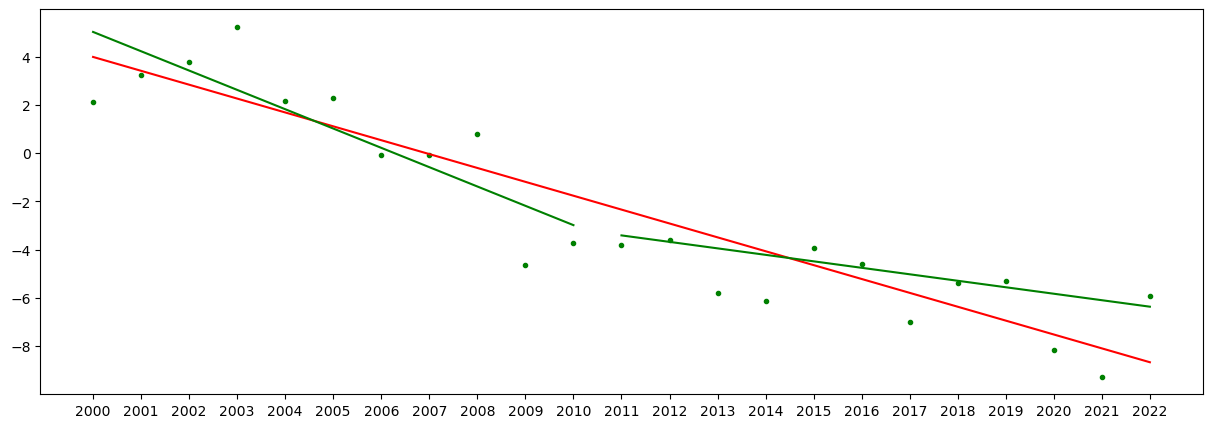

In [10]:
i_year_middle = 11
#### Time interval: 2000-2021
x_years = np.array([i for i in range(len(years))])
mean_setp_glacier_cor_filtered, mean_setp_glacier_cor_fitting, rate_setp_glacier_cor = ransac_fitting(x=x_years, \
                                                                y=mean_setp_glacier_cor, thre_mask=50)
print('Elevation change rate:', rate_setp_glacier_cor[0])

#### Time interval: 2000-2010
mean_setp_glacier_cor_2000_2011_filtered, mean_setp_glacier_cor_2000_2011_fitting, rate_setp_glacier_cor_2000_2011 = ransac_fitting(x=x_years[0:i_year_middle], \
                                                                y=mean_setp_glacier_cor[0:i_year_middle], thre_mask=50)
print('Elevation change rate (2000-2011):', rate_setp_glacier_cor_2000_2011[0])

#### Time interval: 2012-2021
mean_setp_glacier_cor_2012_2022_filtered, mean_setp_glacier_cor_2012_2022_fitting, rate_setp_glacier_cor_2012_2022 = ransac_fitting(x=x_years[i_year_middle:], \
                                                                y=mean_setp_glacier_cor[i_year_middle:], thre_mask=50)
print('Elevation change rate (2012-2022):', rate_setp_glacier_cor_2012_2022[0])

plt.figure(figsize=(15,5))
plt.plot(years, mean_setp_glacier_tilesWeighted.values, '.g')
plt.plot(years, mean_setp_glacier_cor_fitting, '-r')
plt.plot(years[0:i_year_middle], mean_setp_glacier_cor_2000_2011_fitting, '-g')
plt.plot(years[i_year_middle:], mean_setp_glacier_cor_2012_2022_fitting, '-g')



##### 2.1.4 Elevation change rate uncertainty estimation.

In [20]:
#### 1. Time interval: 2000-2021
epsilon = mean_setp_glacier_cor - mean_setp_glacier_cor_fitting
sigma_dh = np.std(epsilon)
sigma_dh_dt = sigma_dh/len(years)
# print('sigma_dh:', sigma_dh)
print('sigma_dh_dt:', sigma_dh_dt)

#### 2. Time interval: 2000-2010
epsilon = mean_setp_glacier_cor[0:i_year_middle] - mean_setp_glacier_cor_2000_2011_fitting
sigma_dh_2000_2011 = np.std(epsilon)
sigma_dh_dt_2000_2011 = sigma_dh_2000_2011/mean_setp_glacier_cor[0:i_year_middle].shape[0]
# print('sigma_dh for 2000-2011:', sigma_dh)
print('sigma_dh_dt for 2000-2011:', sigma_dh_dt_2000_2011)

#### 3. Time interval: 2012-2021
epsilon = mean_setp_glacier_cor[i_year_middle:] - mean_setp_glacier_cor_2012_2022_fitting
sigma_dh_2012_2021 = np.std(epsilon)
sigma_dh_dt_2012_2021 = sigma_dh_2012_2021/mean_setp_glacier_cor[i_year_middle:].shape[0]
# print('sigma_dh for 2000-2012:', sigma_dh)
print('sigma_dh_dt for 2012-2021:', sigma_dh_dt_2012_2021)



sigma_dh_dt: 0.06727068744730079
sigma_dh_dt for 2000-2011: 0.13545523379884955
sigma_dh_dt for 2012-2021: 0.10498832383479423


#### 2.2 Elevation change of tiles.


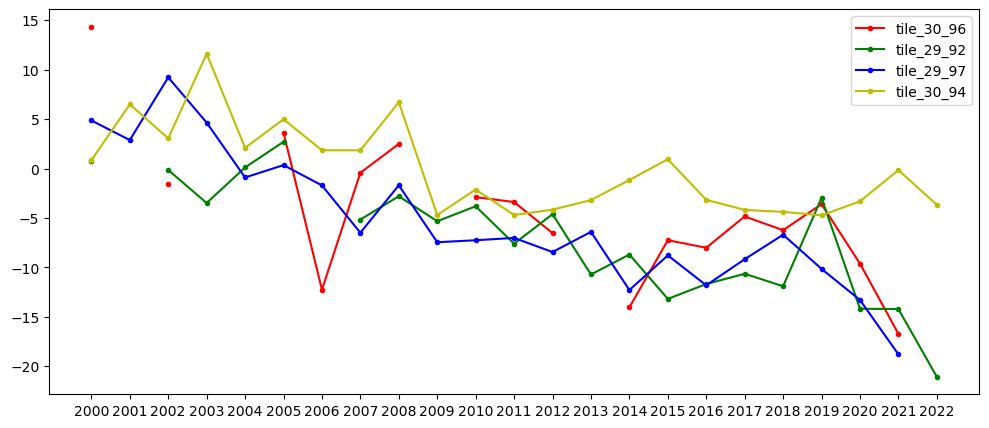

In [21]:
tile_id_1, tile_id_2, tile_id_3, tile_id_4 = 'tile_30_96', 'tile_29_92', 'tile_29_97', 'tile_30_94'
plt.figure(figsize=(12,5))
plt.plot(years, mean_tiles_glacier_binsWeighted.sel(tiles_id = tile_id_1).values, '.-r', label=tile_id_1)
plt.plot(years, mean_tiles_glacier_binsWeighted.sel(tiles_id = tile_id_2), '.-g', label=tile_id_2)
plt.plot(years, mean_tiles_glacier_binsWeighted.sel(tiles_id = tile_id_3), '.-b', label=tile_id_3)
plt.plot(years, mean_tiles_glacier_binsWeighted.sel(tiles_id = tile_id_4), '.-y', label=tile_id_4)
plt.legend()



#### 2.2.1 Tile-based elevation change rate estimation with corrected elevation change, and write out

In [22]:
# tile_id =  'tile_27_98'
tiles_id = mean_tiles_glacier_binsWeighted['tiles_id'].values
rate_tiles = []
rate_error_tiles = []
glacier_area_tiles = {}
for tile_id in tiles_id:
  # tile_id =  'tile_27_98'
  mean_tile_glacier = mean_tiles_glacier_binsWeighted.sel(tiles_id=tile_id).values
  mean_tile_stable = stat_dif_dems_xr['mean_stable_tiles'].sel(tiles_id=tile_id).values
  mean_tile_glacier_cor = mean_tile_glacier - mean_tile_stable
  if not np.isnan(mean_tile_glacier_cor).all():
    mean_tile_glacier_cor_filtered, mean_tile_glacier_cor_fitting, rate_tile_glacier_cor = ransac_fitting(x=x_years, \
                                            y=mean_tile_glacier_cor, thre_mask=50)
    rate_tiles.append(rate_tile_glacier_cor[0])
    ## Uncertainty.
    epsilon = mean_tile_glacier_cor - mean_tile_glacier_cor_fitting
    sigma_dh = np.nanstd(epsilon)
    sigma_dh_dt = sigma_dh/len(years)
    rate_error_tiles.append(sigma_dh_dt)
  else: 
    rate_tiles.append(np.nan)
    rate_error_tiles.append(np.nan)
# rate_tiles



Text(0.5, 1.0, 'elevation change rate of tiles')

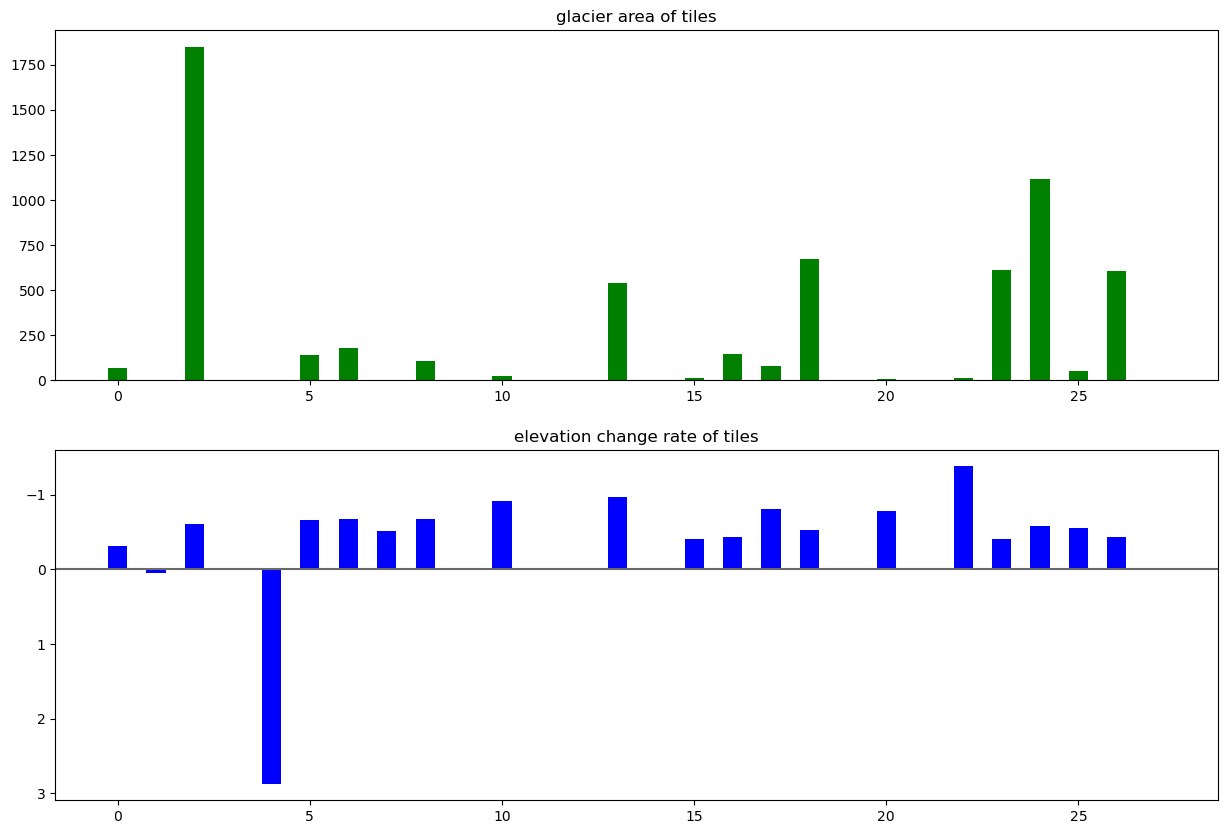

In [23]:
plt.figure(figsize =(15, 10))
num_tiles = len(tiles_id)
width = 0.5
ax1 = plt.subplot(2,1,1)
ax1.bar(np.arange(num_tiles), stat_dif_dems_xr['area_glacier_tiles'].values, color='g', width=width)
plt.title('glacier area of tiles')

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.axhline(y=0, color='dimgray', linestyle='-')
ax2.bar(np.arange(num_tiles), rate_tiles, color='b',width=width)
ax2.invert_yaxis()
plt.title('elevation change rate of tiles')



#### 2.3. Bin-based elevation changes.
##### !!! Note: the elevation change of bins is not corrected because the area of stable region of bins is largely unbalanced. 


In [24]:
### Calculate elevation change rate for each bin.
rate_bins = []
ele_change_bins = []
rate_error_bins = []
for bin_id in mean_bins_glacier_tilesWeighted.bins_id.values:
    ele_change_bin = mean_bins_glacier_tilesWeighted.sel(bins_id=bin_id).values
    ele_change_bin = np.where(ele_change_bin == 0, np.nan, ele_change_bin)
    if not np.isnan(ele_change_bin).all():
        mean_bin_glacier_filtered, mean_bin_glacier_fitting, rate_bin_glacier = ransac_fitting(x=x_years, y=ele_change_bin, thre_mask=50)
        rate_bins.append(rate_bin_glacier[0])
        ele_change_bins.append(ele_change_bin)
        ## Uncertainty.
        epsilon_bin =  ele_change_bin - mean_bin_glacier_fitting
        sigma_dh_bin = np.nanstd(epsilon_bin)
        sigma_dh_dt_bin = sigma_dh/len(years)
        rate_error_bins.append(sigma_dh_dt_bin)
    else:
        rate_bins.append(np.nan)
        ele_change_bins.append(np.nan)
        rate_error_bins.append(np.nan)
area_glacier_bins = stat_dif_dems_xr['area_glacier_tiles_bins'].sum(dim='tiles_id').values
# ransac_coef_bins


Text(0.5, 1.0, 'selected tile')

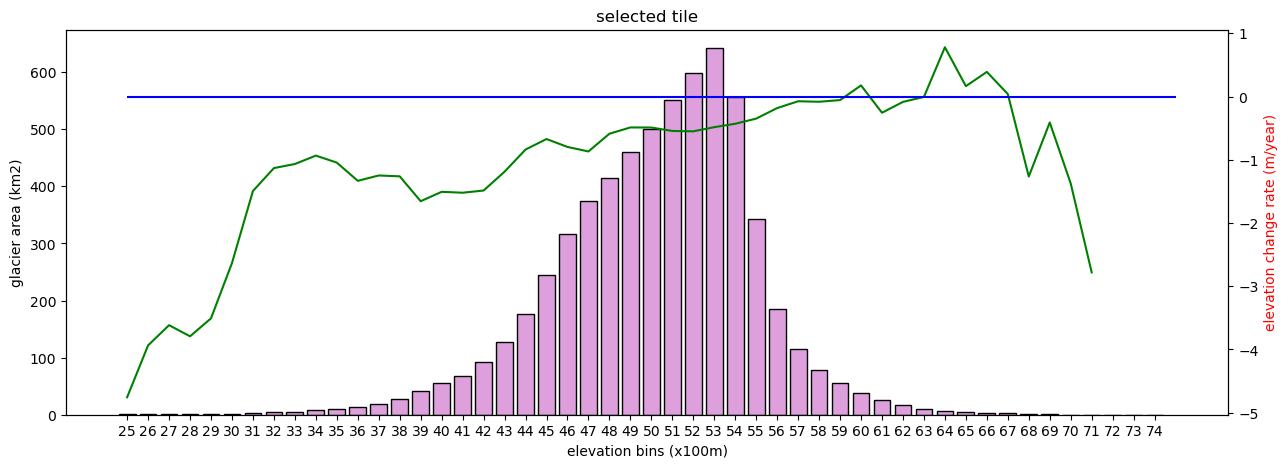

In [25]:
bins_id_start = [bin_id[0:2] for bin_id in bins_id]
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111) # Create matplotlib axes
ax1.bar(bins_id_start, area_glacier_bins, color ='Plum', edgecolor ='black')
ax1.set_ylabel('glacier area (km2)')
ax1.set_xlabel('elevation bins (x100m)')
ax2 = ax1.twinx() # Create another axes that shares the same x-axis as ax.
ax2.set_ylabel('elevation change rate (m/year)', color='red')
ax2.plot(rate_bins, 'g')
ax2.hlines(y=0, xmin=0, xmax=50, colors='blue')
# plt.xticks([1, 25, 50], [2500, 5000, 7500])
plt.xlabel('elevation (m)')
plt.title('selected tile')


#### **3. Write out the elevation change result.**


In [28]:

### 3) write out statistic of stable region to the xarray .nc file.
tiles_lat, tiles_lon = [], []
for tile_id in tiles_id:
    tiles_lat.append(int(tile_id[5:7]))
    tiles_lon.append(int(tile_id[8:]))
    
### Conver to xarray data.
result_dems_xr =xr.Dataset(
        {
        'tiles_lat': (["tiles_id"], tiles_lat),
        'tiles_lon': (["tiles_id"], tiles_lon),
        'area_glacier_bins': (["bins_id"], area_glacier_bins),
        'area_glacier_tiles': (["tiles_id"], stat_dif_dems_xr['area_glacier_tiles'].values),
        ### setp
        'ele_change_setp_cor': (["years"], mean_setp_glacier_cor),
        'ele_change_setp_cor_error': (["years"], std_setp_glacier_cor),           
        'ele_change_setp_cor_fitting': (["years"], mean_setp_glacier_cor_fitting),
        'rate_setp': rate_setp_glacier_cor[0],
        'rate_setp_error': sigma_dh_dt,
        ### tiles
        'rate_tiles': (["tiles_id"], rate_tiles),
        'rate_tiles_error': (["tiles_id"], rate_error_tiles),
        ### bins
        'rate_bins': (["bins_id"], rate_bins),
        'rate_bins_error': (["bins_id"], rate_error_bins),
        },
        coords={'tiles_id': tiles_id,
                'bins_id': bins_id,
                'years': years})

if os.path.exists(path_result_dems): os.remove(path_result_dems)
result_dems_xr.to_netcdf(path_result_dems)

